In [5]:
import numpy as np 
import pandas as pd 
import os
import cv2

In [6]:
labels = os.listdir(r"archive/train")
labels

['Closed', 'no_yawn', 'Open', 'yawn']

In [7]:
import matplotlib.pyplot as plt

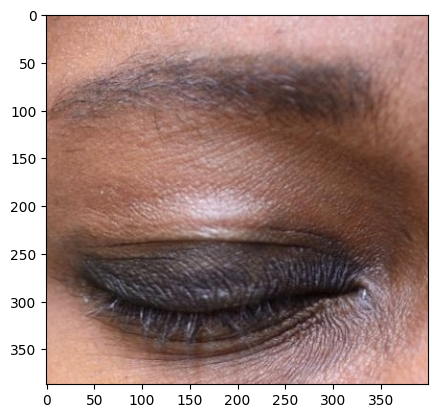

In [8]:
plt.imshow(plt.imread(r"archive/train/Closed/_110.jpg"))

### Visualize yawn image(Background is unnecessary. We need only face image array)

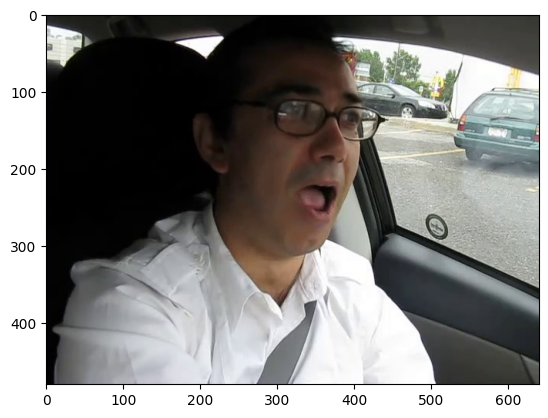

In [9]:
image = plt.imread(r"archive/train/yawn/110.jpg")
plt.imshow(image)

In [10]:
image.shape

(480, 640, 3)

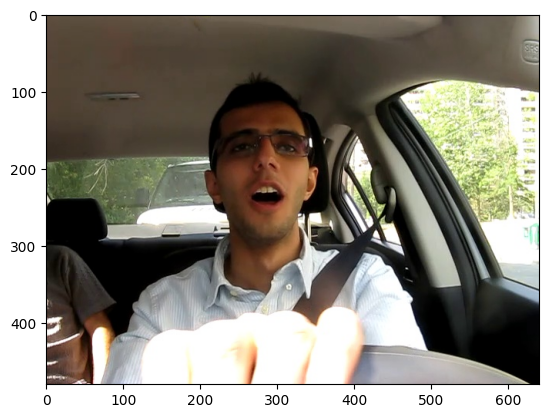

In [11]:
plt.imshow(plt.imread(r"archive\train\yawn\125.jpg"))

### Take only face(For yawn and not_yawn)

In [12]:
def face_for_yawn(direc=r"F:\KANISHK\projects_null_class\drowsiness\archive\train" , face_cas_path=r"F:\KANISHK\projects_null_class\drowsiness\archive(1)\haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


### For Closed and Open eye

In [13]:
def get_data(dir_path=r"F:\KANISHK\projects_null_class\drowsiness\archive\train", face_cas=r"archive(1)\haarcascade_frontalface_default.xml", eye_cas=r"archive(1)\haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

data_train = get_data()

2
3


### Extend data and Convert arraySeparate label and features

In [14]:
def append_data():
    # Retrieve the data
    yaw_no = face_for_yawn()  # Assumes face_for_yawn() returns list of [feature, label] pairs
    data = get_data()          # Assumes get_data() returns list of [feature, label] pairs

    # Combine both data lists
    yaw_no.extend(data)

    # Separate features and labels
    X = [item[0] for item in yaw_no]  # Extract features
    y = [item[1] for item in yaw_no]  # Extract labels

    # Convert X and y to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

# Get the data and labels
X, y = append_data()

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

0
1
2
3
Features shape: (1925, 145, 145, 3)
Labels shape: (1925,)


### Reshape the Array

In [15]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

### LabelBinarizer

In [16]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [17]:
y = np.array(y)

### Train Test split

In [18]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

### length of X_test

In [19]:
len(X_test)

578

### Import some dependencies

In [20]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

### Data Augmentation

In [21]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

### model

In [22]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 143, 143, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 69, 69, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,140 (1.89 MB)

 Trainable params: 495,140 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))


C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - accuracy: 0.3652 - loss: 1.2814 - val_accuracy: 0.7318 - val_loss: 0.7952
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.7588 - loss: 0.6166
Epoch 3/50


C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


43/43 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.7918 - loss: 0.4955 - val_accuracy: 0.8616 - val_loss: 0.3412
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.8544 - loss: 0.3555
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8547 - loss: 0.3455 - val_accuracy: 0.8391 - val_loss: 0.3888
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.8573 - loss: 0.3380
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.8723 - loss: 0.3175 - val_accuracy: 0.9066 - val_loss: 0.2256
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.8930 - loss: 0.2629
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9124 - loss: 0.2374 - val_accuracy: 0.9100 - val_loss: 0.2118
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.8934 - loss: 0.2585
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.9172 - loss: 0.2082 - val_accuracy: 0.9152 - val_loss: 0.1930
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━

In [30]:
print("Training accuracy length:", len(accuracy))
print("Validation accuracy length:", len(val_accuracy))
print("Training loss length:", len(loss))
print("Validation loss length:", len(val_loss))

NameError: name 'accuracy' is not defined

In [32]:
epochs = range(min(len(accuracy), len(val_accuracy)))

plt.plot(epochs, accuracy[:len(epochs)], "b", label="training accuracy")
plt.plot(epochs, val_accuracy[:len(epochs)], "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss[:len(epochs)], "b", label="training loss")
plt.plot(epochs, val_loss[:len(epochs)], "r", label="validation loss")
plt.legend()
plt.show()

NameError: name 'accuracy' is not defined

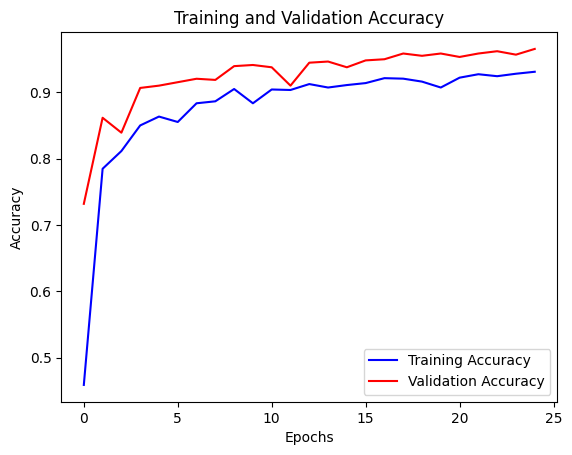

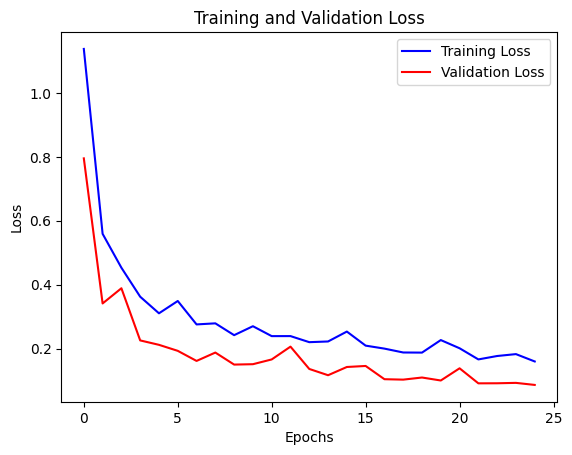

In [34]:
# Ensure that both lists are the same length by slicing to the minimum length
min_len = min(len(accuracy), len(val_accuracy))
epochs = range(min_len)

# Plot with adjusted lengths
plt.plot(epochs, accuracy[:min_len], "b", label="Training Accuracy")
plt.plot(epochs, val_accuracy[:min_len], "r", label="Validation Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# Similarly for loss
min_loss_len = min(len(loss), len(val_loss))
plt.plot(range(min_loss_len), loss[:min_loss_len], "b", label="Training Loss")
plt.plot(range(min_loss_len), val_loss[:min_loss_len], "r", label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [35]:
print(len(accuracy), len(val_accuracy), len(loss), len(val_loss))

50 25 50 25


In [36]:
model.save("drowiness_.h5")

In [37]:
model.save("drowiness_.keras")

In [41]:
import numpy as np

# Get predicted probabilities
predictions = model.predict(X_test)

# Convert probabilities to class labels (for multiclass classification)
predicted_classes = np.argmax(predictions, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 503ms/step


In [42]:
predicted_classes

array([3, 3, 2, 3, 0, 3, 3, 2, 0, 2, 3, 3, 3, 2, 2, 2, 3, 3, 0, 3, 3, 3,
       2, 0, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2, 1, 3, 3, 3, 0, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 3, 3, 3, 0, 2, 1, 3, 3, 2, 2, 2, 0, 3, 3, 3, 3, 2, 3,
       2, 3, 3, 2, 1, 3, 3, 3, 2, 0, 0, 3, 3, 3, 2, 0, 3, 2, 2, 2, 2, 0,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 0, 3, 0, 2, 3, 3, 0, 2, 3,
       0, 1, 2, 0, 0, 3, 3, 3, 2, 2, 3, 3, 3, 0, 1, 2, 3, 3, 2, 0, 3, 3,
       1, 3, 1, 2, 3, 3, 2, 3, 2, 2, 2, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 1, 1, 0, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 3, 0, 2, 3, 0, 2, 1, 3, 2, 3, 0, 2, 0, 0, 3, 2, 2, 3, 3, 3, 0,
       3, 3, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 3, 3,
       1, 0, 2, 3, 3, 3, 3, 0, 0, 2, 0, 0, 3, 3, 1, 3, 3, 0, 3, 3, 0, 1,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 0, 2, 2, 2, 0, 3, 3, 2, 2,
       3, 2, 2, 0, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 2,
       2, 0, 2, 2, 2, 3, 3, 0, 2, 2, 0, 3, 2, 3, 1,

In [43]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [45]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), predicted_classes, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.63      0.90      0.74        63
     no_yawn       0.84      0.42      0.56        74
      Closed       0.98      0.84      0.90       215
        Open       0.83      0.98      0.90       226

    accuracy                           0.85       578
   macro avg       0.82      0.79      0.78       578
weighted avg       0.87      0.85      0.84       578



In [47]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("drowiness_.h5")

In [48]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare(r"archive\train\no_yawn\1067.jpg")])
np.argmax(prediction)

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer. Received: the structure of inputs=('*',)
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


1

In [49]:
prediction = model.predict([prepare(r"archive\train\Closed\_104.jpg")])
np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


2

In [50]:
prediction = model.predict([prepare(r"archive\train\yawn\12.jpg")])
np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


0